In [115]:
import sys
print(sys.version)
import itertools

import numpy as np
import qutip as qp
import matplotlib.pyplot as plt

3.12.5 | packaged by conda-forge | (main, Aug  8 2024, 18:24:51) [MSC v.1940 64 bit (AMD64)]


# Transmon diagonalization

In [116]:
class TmonParams:
    def __init__(
            self, EC=0.2, EJ=22, alpha=0.25, flux_ext=0, c1=1, c2=0,
            basis: str="charge", eigensystem_n: int=3, charge_n_max: int=5
        ):
        r"""
        Parameters
        ----------
        EC: float
            Ec = \frac{e^2}/{2 h C} [GHz]
            Ec entries hamiltonian as `4 Ec n^2`
        EJ: float
            EJ = \frac{Ic}{2e} \frac{1}{2pi} [GHz] 
        alpha: float
            E_{J1}/E_{J2} in [0, 1]
        flux_ext: float
            external flux normalized in [0, 1]
        c1: float
            external flux coefficient at branch E_{J1}
        c2: float
            external flux coefficient at branch E_{J2}
         tmon_params: TmonParams
            Transmon model physical parameters
        basis: str
            Type of basis to solve in "charge" or "flux"
        eigensystem_n: int
            number of eigenfunctions to find
        charge_n_max: int
            size of charge basis
        """
        self.EC: float = EC
        self.EJ: float = EJ
        self.alpha: float = alpha
        self.flux_ext: float = flux_ext
        self.c1: float = c1
        self.c2: float = c2

        # eigenvectrors basis (charge or flux)
        self.basis: str = basis
        self.eigensystem_n: int = eigensystem_n  # amount of vectors in eigenbasis to find
        self.charge_n_max: int = charge_n_max  # charge basis size

    def get_pars_tuple(self) -> tuple[float]:
        return (self.EC, self.EJ, self.alpha, self.flux_ext, self.c1, self.c2)

class Tmon:
    def __init__(self, tmon_params: TmonParams=TmonParams()):
        self.pars: TmonParams = tmon_params

    @staticmethod    
    def construct_ec_cb(tmon_pars) -> np.ndarray:
        r"""
        H 4*E_C*n^2
        H = 4*E_C*\hat{n}^2
        """
        pars = tmon_pars
        diag_entries = [i**2 for i in range(-pars.charge_n_max, pars.charge_n_max + 1)]
        ec = 4*pars.EC*qp.qdiags(diagonals=[diag_entries], offsets=[0])
        return ec

    @staticmethod
    def construct_ej_cb(tmon_pars) -> np.ndarray:
        r"""
        - alpha * E_J * cos(phi - c1*flux_ext) - E_J * cos(phi - c2*flux_ext)
         - \alpha* E_J * \cos({\hat{\phi} - c1*\phi_{ext}}) - E_J * \cos({\hat{\phi} - c2*\phi_{ext}})
        """
        def get_ejj_cb(ej, phi_ext):
            # return ej*cos(\op(phi) - phi_ext) in charge basis
            ejj = qp.qdiags(
                diagonals=[
                    (ej*np.exp(-1j*2*np.pi*phi_ext))*np.ones(2*tmon_pars.charge_n_max),  # upper diagonal
                    (ej*np.exp(1j*2*np.pi*phi_ext))*np.ones(2*tmon_pars.charge_n_max)  # lower diagonal
                ],
                offsets=[1, -1]
            )
            return 1/2*ejj
        pars = tmon_pars
        Ejj1 = get_ejj_cb(ej=pars.alpha*pars.EJ, phi_ext=pars.c1*pars.flux_ext)
        Ejj2 = get_ejj_cb(ej=pars.EJ, phi_ext=pars.c2*pars.flux_ext)
        return -Ejj1 - Ejj2
    
    @staticmethod
    def get_h_cb(tmon_pars: TmonParams) -> qp.Qobj:
        r"""
        H = 4*E_C*n^2 - alpha * E_J * cos(phi - c1*flux_ext) - E_J * cos(phi - c2*flux_ext)
        H = 4*E_C*\hat{n}^2 - \alpha* E_J * \cos({\hat{\phi} - c1*\phi_{ext}}) - E_J * \cos({\hat{\phi} - c2*\phi_{ext}})
        """
        Hc = Tmon.construct_ec_cb(tmon_pars=tmon_pars)
        Hj = Tmon.construct_ej_cb(tmon_pars=tmon_pars)
        return Hc + Hj

In [117]:
phi_ext_n : int = 20
phi_ext_arr = np.linspace(start=0, stop=1, num=phi_ext_n, endpoint=False)

eigvals_n = 3
evals_arr = []
evecs_arr = []


for phi_idx, phi_ext in enumerate(phi_ext_arr):
    h = Tmon.get_h_cb(TmonParams(flux_ext=phi_ext))
    evals, evecs = h.eigenstates(eigvals=eigvals_n)
    evals_arr.append(evals[1:2] - evals[0])
    evecs_arr.append(evecs)

evals_arr = np.array(evals_arr)
evecs_arr = np.array(evecs_arr)

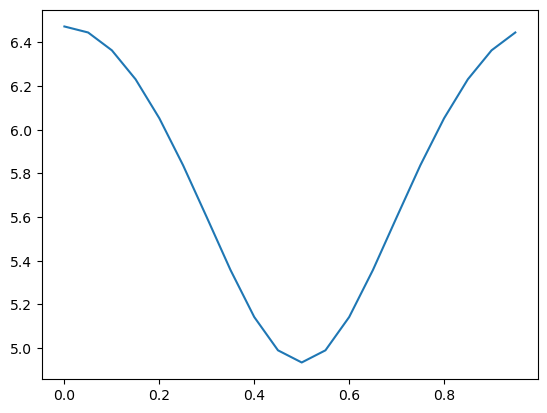

In [118]:
fig, ax = plt.subplots(1,1)
for evals in evals_arr.T:
    ax.plot(phi_ext_arr, evals)

# Resonator + Tmon diagonalization

In [124]:
class RoResParams:
    def __init__(self, freq=7.2, kappa=2e-3, gc=12e-3, max_excitations=5) -> None:
        r"""
        Physical paramters of a lamda/4 coplanar waveguide readout resonator
        freq: float
            [GHz] resonator frequency
        kappa: float
            [Ghz] photon loss rate into readout waveguide
        gc: float
            [Ghz] coupling between resonator and qubit $H_{int} = g_c \sigma_x (a + a^{dag})$
        max_excitations: int
        """
        self.freq = freq
        self.kappa = kappa
        self.gc = gc

        self.max_excitations = 5

class RoResonator:
    def __init__(self, pars: RoResParams = RoResParams()):
        self.pars = pars

    @staticmethod
    def get_h_osc(pars: RoResParams = RoResParams()):
        r"""
        Oscillator energy
        E_r/h = \nu_r a a^{\dag}
        """
        return pars.freq*qp.num(N=pars.max_excitations)

In [155]:
t_pars = TmonParams(eigensystem_n=4)
r_pars = RoResParams()
phi_ext_arr = np.linspace(start=0, stop=1, num=20, endpoint=False)
n_op_eigh_list = []
evals_arr = []
evecs_arr = []
# prepare many-time used operators
n_op = qp.charge(Nmax=t_pars.charge_n_max)
pos = np.sqrt(2) * qp.position(N=r_pars.max_excitations)
h_osc = qp.tensor(qp.identity(t_pars.eigensystem_n), RoResonator.get_h_osc(r_pars))

for phi in phi_ext_arr:
    t_pars.flux_ext = phi
    h_tmon_cb = Tmon.get_h_cb(tmon_pars=t_pars)

    evals, evecs_Sm = h_tmon_cb.eigenstates(eigvals=t_pars.eigensystem_n)
    # charge operator in eigenbasis
    n_op_eigh = np.empty((len(evals), len(evals)), dtype=complex)
    for (i, v1), (j, v2) in itertools.product(enumerate(evecs_Sm), enumerate(evecs_Sm)):
        n_op_eigh[i,j] = v1.full().T.dot(n_op.full()).dot(v2.full())[0,0]
    n_op_eigh = qp.Qobj(n_op_eigh)
    
    h_q = qp.tensor(qp.qdiags(evals-evals[0]), qp.identity(r_pars.max_excitations)) 
    h_int = r_pars.gc*np.sqrt(2)*qp.tensor(n_op_eigh, pos)
    h = h_q + h_osc + h_int
    evals, evecs = h.eigenstates(eigvals=4)
    evals_arr.append(evals)
    evecs_arr.append(evecs)

evals_arr = np.array(evals_arr).T

c:\Users\botan\anaconda3\envs\qp-nbs\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\botan\anaconda3\envs\qp-nbs\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


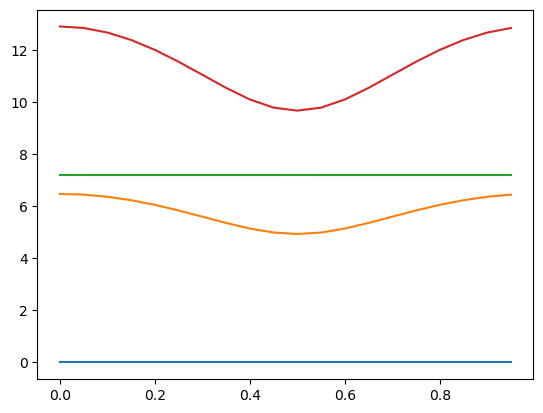

In [156]:
fig, ax = plt.subplots(1,1)
for evals in (evals_arr - evals_arr[0]):
    ax.plot(phi_ext_arr, evals)

## Flux operator in cooper pairs excess number basis (charge basis).
$$\cos({\hat{\phi} - \phi_{ext}}) = \frac{1}{2} \left( e^{-i\phi_{ext}} \left( \sum_{m=-\infty}^{\infty} \ket{m+1}\bra{m} \right) +  e^{i \phi_{ext}} \left( \sum_{m=-\infty}^{\infty}\ket{m}\bra{m-1} \right) \right)$$


### Proof
We have $\cos(\hat{\phi} - \phi_{ext})$ in josephson junction's hamiltonian and wish compute hamiltonian in charge basis.


$\cos({\hat{\phi} - \phi_{ext}}) = \frac{1}{2} (e^{i (\hat{\phi} - \phi_{ext})} + e^{ -i (\hat{\phi} - \phi_{ext})}) = \frac{1}{2} (e^{-i\phi_{ext}}e^{i \hat{\phi}} + e^{i\phi_{ext}}e^{-i \hat{\phi}})$.

All the data on canonical pulse and coordinate relations will be based on relation 
$$ [\hat{\phi}, \hat{n}] = i \hat{1} $$

We will need the following equality

$$ [e^{i \hat{\phi}}, \hat{n}] = \sum_{k=0}^{\infty} \frac{i^k}{k!}[\phi^k, n] = - e^{i \hat{\phi}} $$


Proof:
$$ [\phi^k, n] = \phi [\phi^{k-1}, n] + [\phi, n] \phi^{k-1}, \;\; k \geq 1 $$
$$ a_k = [\phi^k, n], \;\; a_k = \phi a_{k-1} + i \phi^{k-1} $$
$$ a_k = c_k \phi^{k-1} $$
$$ c_k = c_{k-1} + i, \; \; c_1 = i \; \rightarrow \; c_k = i k $$
$$ [\phi^k, n] = i k \phi^{k-1} $$
$$ [e^{i \phi}, n] = \sum_{k=1}^{\infty} \frac{i^k}{k!} (i k \phi^{k-1})  = \sum_{k=0}^{\infty} (i^2)\frac{i^{k-1}}{(k-1)!} \phi^{k-1} = - e^{i \phi} $$

Now we can apply both parts to the vector $\ket{m}$, such that $\hat{n}\ket{m} = m\ket{m}$
$$ \hat{n} \ket{m} - \hat{n} e^{-i \hat{\phi}} \ket{m} = e^{-i\hat{\phi}} \ket{m} $$
$$ \hat{n} e^{-i \hat{\phi}} \ket{m} = (m - 1) e^{-i \hat{\phi}} \ket{m}$$

Hence $e^{i \hat{\phi}} \ket{m}$ is the eigenvector of the operator $\hat{n}$ with the eigenvalue $m-1$:
$$ e^{-i \hat{\phi}} \ket{m} = c_m \ket{m-1} $$

If $\hat{\phi}$ is hermitian then $e^{-i\hat{\phi}}$ is unitary. Adding that $\ket{n}$ are normalized $c_m = e^{i \alpha_m}, \; \alpha_m \in [0,2\pi)$
$$ e^{-i \hat{\phi}} \ket{m} = e^{i \alpha_m} \ket{m-1} $$


Using that (todo: derive from $[\phi, n] = i$ and formal series/generalized functions)
$$ \hat{n} = -i \frac{\partial}{\partial \phi} $$
or if written properly in braket notation with use of a generalized Loran-Schwartz functions:
$$ \bra{\phi}\hat{n}\ket{\psi} = i\delta'(\psi - \phi) $$

One can establish a connection between canonical momentum and coordinate basises.
Writing equation for momentum eigenfunctions in coordinate basis:
$$ -i\partial_{\phi} \psi_m = m \psi_m $$
$$ \psi_m(\phi) = C_m e^{-i m \phi} $$
No matter what variable types are momentum and coordinate (discrete, continious, periodic) $\phi$ normalization gives $\lvert C_m \rvert = 1/\sqrt{2 \pi}$
We choose
$$ \psi_m(\phi) = \frac{1}{\sqrt{2 \pi}} e^{-i m \phi}

In bracket notation
$$ \braket{\phi \vert m} = \frac{1}{\sqrt{2 \pi}} e^{i m \phi} $$
$$ \braket{m \vert\phi} = \frac{1}{\sqrt{2 \pi}} e^{-i n \phi}$$

$\ket{\phi}$ can be represented in a charge basis:
$$ \ket{\phi} = \sum_{m=-\infty}^{\infty} \frac{1}{\sqrt{2 \pi}} e^{-i m \phi} \ket{m} $$

Assumig that $\hat{\phi}$ and $e^{i \hat{\phi}}$ has the same eigensystems
$$e^{i \hat{\phi}}\ket{\phi} = e^{i \phi}\ket{\phi} = $$

On the other hand :
$$e^{i \hat{\phi}} \ket{\phi} = \sum_{m=-\infty}^{\infty} \braket{m \vert \phi} e^{i \hat{\phi}} \ket{m} = \sum_{m=-\infty}^{\infty} \braket{m \vert \phi} c_m \ket{m-1} $$

Equalizing both results for $e^{i \hat{\phi}}\ket{\phi}$ and projecting them on the momentum eigenfunction $\ket{k}$
$$ e^{i \phi} \braket{k \vert \phi} = \braket{k+1 \vert \phi} c_{k+1} $$
$$ c_m = e^{i \phi} \frac{\braket{m-1 \vert \phi}}{\braket{m \vert \phi}} = 1$$

We have derived
$$ e^{i \hat{\phi}} = \sum_{m=-\infty}^{\infty}\ket{m-1}\bra{m}$$

$$\cos({\hat{\phi} - \phi_{ext}}) = \frac{1}{2} \left( e^{-i\phi_{ext}} \left( \sum_{m=-\infty}^{\infty} \ket{m-1}\bra{m} \right) +  e^{i \phi_{ext}} \left( \sum_{m=-\infty}^{\infty}\ket{m+1}\bra{m} \right) \right)$$

## Interaction picture for resonator operators
$$ \hat{H}_0/\hbar = \omega_r \hat{a}^{\dag} \hat{a} $$
$$ \hat{a_I} = \hat{a} e^{- i \omega_r t} $$

### Proof

$$ a_I = U_0^{\dag} a U_0 \quad U_0 = \exp(-i H_0/\hbar t) $$
$$ \frac{d a_I}{d t} =  i\omega_r [\hat{n}, a_I] = \big\vert [\hat{n}, U_0] = 0 \big\vert = - i \omega_r a_I $$